In [1]:
#!/usr/bin/env python3

%matplotlib inline
# Basic import
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint


# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F


# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

# Optuna
import optuna
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour


#Import sys
import sys

## Dynamics generation

/var/folders/m_/s5f9rn3j5nb17nbdtfyy_nm80000gn/T/ipykernel_1030/1719761136.py:17: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


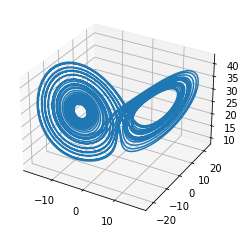

In [2]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, dt)

states_dataset = odeint(f, state0, t)


fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states_dataset[100:, 0], states_dataset[100:, 1], states_dataset[100:, 2])



In [3]:
### Convert to tensor
l_seq = 20
num_sequences = int(4000/l_seq)

states = torch.tensor(states_dataset, requires_grad=True,dtype=torch.float)
states = torch.reshape(states, (num_sequences, l_seq, 3))

### Dataloader
dataloader = DataLoader(states, batch_size=16, shuffle=True)
print(next(iter(dataloader)).shape)

torch.Size([16, 20, 3])


## Network definition

In [4]:
class Network(nn.Module):  
    def __init__(self, input_size, hidden_units, layers_num, drop_p=0):
        # Call the parent init function (required!)
        super().__init__()
        # Define recurrent layers
        self.rnn = nn.LSTM(input_size=input_size, 
                           hidden_size=hidden_units,
                           num_layers=layers_num,
                           dropout=drop_p,
                           batch_first=True)
        # Define output layer
        self.out = nn.Linear(hidden_units, input_size)
        print("Network initialized")
        
    def forward(self, x, state=None):
        # LSTM
        x, rnn_state = self.rnn(x, state)
        # Linear layer
        x = self.out(x)
        # Remember to return also the RNN state, you will need it to generate data
        return x, rnn_state

## Purely data driven approach

In [43]:
# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_dd = Network(input_size, hidden_units, layers_num, drop_p)

# Define the optimizer
optimizer = optim.Adam(net_dd.parameters())

# Define the loss function
loss_fn = nn.MSELoss()

#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_dd.to(device)
# Network in training mode (enable stochastic layers, e.g. dropout)
net_dd.train()

### Iterate through the dataloader for "num_epochs"
num_epochs = 2000

# Create pbar 
pbar = tqdm(range(num_epochs))

# Epoch losses 
log_loss = []

for num_epoch in pbar:
    epoch_losses = []
    for batch_sample in dataloader:

        ### Move samples to the proper device
        batch_sample = batch_sample.to(device)

        ### Prepare network input and labels
        net_input  = batch_sample[:, :-1, :]
        labels = batch_sample[:, 1:, :]

        ### Forward pass
        # Clear previous recorded gradients
        optimizer.zero_grad()
        # Forward pass
        net_out, _ = net_dd(net_input) # we do not need the rnn state at this point, we can ignore the output with "_"
    
        ### Update network
        # Evaluate loss (pay attention to the proper tensor shapes)
        loss = loss_fn(net_out, labels)
    
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Save batch loss
        epoch_losses.append(loss.data.cpu().numpy())
    # Compute epoch loss
    epoch_loss = np.mean(epoch_losses)
    
    # Append loss
    log_loss.append(epoch_loss)
    
    # Set description
    pbar.set_description("Train loss: %s" %round(epoch_loss,2))
  

Network initialized
Training device: cpu


Train loss: 0.78: 100%|█████████████████████| 2000/2000 [01:33<00:00, 21.32it/s]


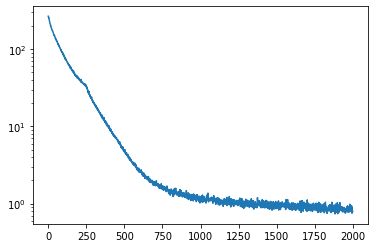

In [6]:
# Plot losses
plt.semilogy(range(num_epochs), log_loss)

In [56]:
### Find initial state of the RNN

# Prepare input
seed_input = torch.tensor((1,1,1), dtype=torch.float).unsqueeze(0).unsqueeze(0)
seed_input = seed_input.to(device)
net_dd.train()

with torch.no_grad():
    # Forward pass
    net_out, initial_net_state = net_dd(seed_input)
    
print(net_out.shape)
print(initial_net_state[0].shape)

### Generate a trajectory with network

net_input = torch.tensor((1,1,1), dtype=torch.float).unsqueeze(0).unsqueeze(0)
net_state = initial_net_state

net_states = []
for i in range(4000):
    with torch.no_grad():
        net_input = net_input.to(device)
    
        # Forward pass
        net_input, net_state = net_dd(net_input, net_state)
        
        net_states.append(net_input[-1].squeeze().numpy())

torch.Size([1, 1, 3])
torch.Size([2, 1, 10])


(4000, 3)


Text(0.5, 0.92, 'True dynamics')

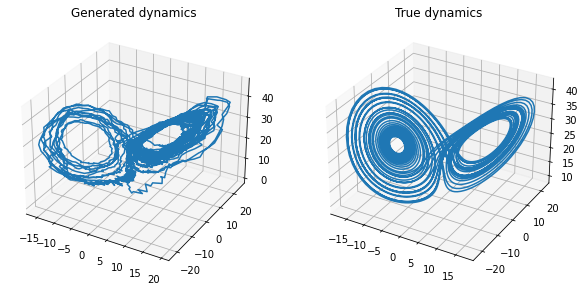

In [57]:
net_states = np.array(net_states)
print(net_states.shape)

fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
ax1.plot(net_states[100:, 0], net_states[100:, 1], net_states[100:, 2])
ax1.set_title("Generated dynamics")
ax2.plot(states_dataset[100:, 0],states_dataset[100:, 1], states_dataset[100:, 2])
ax2.set_title("True dynamics")

## Physical informed dynamics

In [21]:
# Parameters
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01
batch_size = 1
len_seq = 20

# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_pi = Network(input_size, hidden_units, layers_num, drop_p)


# Vector field for Lorenz 63 system, standard version
def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives



# Define a function to create the initial condition
class Initializer():
    def __init__(self, dt, batch_size, len_seq, f):
        self.dt = dt
        self.batch_size = batch_size
        self.len_seq = len_seq
        self.f = f
        
    def __call__(self):
        states_seq = []
        for batch in range(self.batch_size):
            # Uniformly choose initial condition
            state0 = [1.0,1.0,1.0]
            
            # Genrate vector of time steps
            t = np.arange(0.0, dt*self.len_seq, dt)
            
            # Integrate initial dynamics
            states = odeint(f, state0, t)
            
            # Append
            states_seq.append(states)
        
        # Convert to numpy array first
        states_seq = np.array(states_seq)
        # Convert to torch tensor
        states_seq = torch.tensor(states_seq,dtype=torch.float, requires_grad=True)
        
        return states_seq
        


# Define the vector field for Lorenz 63 system, torch tensor
class L63_field():
    def __init__(self,  rho, sigma, beta):
        self.rho=rho
        self.sigma=sigma
        self.beta=beta
        
    def __call__(self,state):
        field = torch.clone(state)
        field[...,0] = self.sigma*torch.sub(state[...,1],state[...,0])
        field[...,1] = torch.sub(state[...,0]*torch.sub(self.rho,state[...,2]),state[...,1])
        field[...,2] = torch.sub(state[...,0]*state[...,1],self.beta*state[...,2])

        return field

# Physical informed loss for a generic dynamical system
class PILoss(nn.Module):
    def __init__(self, dt, field):
        super(PILoss, self).__init__()
        self.dt = dt
        self.field = field

    def forward(self, state, next_state):
        # Compute derivative term
        der_term = self.field(state)
        # Compute rhs
        rhs = state + self.dt*der_term
        # Compute loss of the derivative function
        pi_loss = torch.mean((next_state-rhs)**2)
        # Add initial loss on initial condition
        ic_loss = 0# torch.mean((next_state[:,1,:]-state[:,0,:])**2)
            
        return pi_loss + ic_loss


# Define vector field
field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0)

# Define initial condition operator
init = Initializer(dt, batch_size, len_seq, f)

# Define the optimizer
optimizer = optim.Adam(net_pi.parameters())

# Define loss functions
piloss_fn = PILoss(dt,field)
loss_fn = nn.MSELoss()

Network initialized


Text(0, 0.5, 'Exploration profile (beta)')

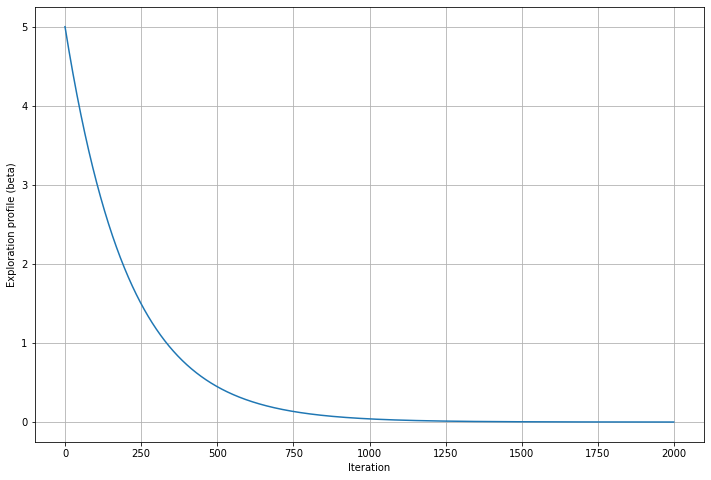

In [22]:
# Retrieve losses
log_loss = []

# Iterate through the dataloader for "num_epochs"
num_epochs = 2000

### Define exploration profile
initial_value = 5
exp_decay = np.exp(-np.log(initial_value) / num_epochs * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
beta = [initial_value * (exp_decay ** i) for i in range(num_epochs)]
### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(beta)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (beta)')


In [23]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_pi.to(device)
# Network in training mode (enable stochastic layers, e.g. dropout)
net_pi.train()



# Create pbar 
pbar = tqdm(range(num_epochs))

for epoch_num in pbar:
    epoch_losses = []
    
    i = 0
    for batch_sample in dataloader:
        
        ### Move samples to the proper device
        batch_sample = batch_sample.to(device)

        ### Prepare network input and labels
        net_input  = batch_sample[:, :-1, :]
        labels = batch_sample[:, 1:, :]

        ### Forward pass
        # Clear previous recorded gradients
        optimizer.zero_grad()
        # Forward pass
        net_out, _ = net_pi(net_input) # we do not need the rnn state at this point, we can ignore the output with "_"
    
        ### Update network
        # Evaluate data driven loss
        dd_loss = loss_fn(net_out, labels)
        # Evaluate physical informed loss
        pi_loss = piloss_fn(net_input,net_out)
        
        loss = beta[i]*dd_loss + pi_loss
    
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Save batch loss
        epoch_losses.append(loss.data.cpu().numpy())
        
        # Update counter
        i = i+1
        
  
    # Compute epoch loss
    epoch_loss = np.mean(epoch_losses)
    
    # Set description
    pbar.set_description("Train loss: %s" %round(np.mean(epoch_losses),3))
    
    # Append
    log_loss.append(epoch_loss)

    

Training device: cpu


Train loss: 4.645: 100%|████████████████████| 2000/2000 [01:32<00:00, 21.70it/s]


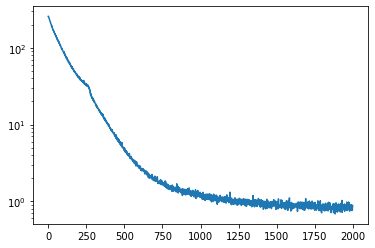

In [28]:
# Plot losses
plt.semilogy(range(num_epochs), log_loss)

In [41]:
### Find initial state of the RNN

# Prepare input
seed_input = torch.tensor((1,1,1), dtype=torch.float).unsqueeze(0).unsqueeze(0)
seed_input = seed_input.to(device)
net_pi.eval()

with torch.no_grad():
    # Forward pass
    net_out, initial_net_state = net_pi(seed_input)
    
print(net_out.shape)
print(initial_net_state[0].shape)

### Generate a trajectory with network

net_input = torch.tensor((1,1,1), dtype=torch.float).unsqueeze(0).unsqueeze(0)
net_state = initial_net_state

net_states = []
for i in range(4000):
    with torch.no_grad():
        net_input = net_input.to(device)
    
        # Forward pass
        net_input, net_state = net_pi(net_input, net_state)
        
        net_states.append(net_input[-1].squeeze().numpy())


torch.Size([1, 1, 3])
torch.Size([2, 1, 10])


(4000, 3)


Text(0.5, 0.92, 'True dynamics')

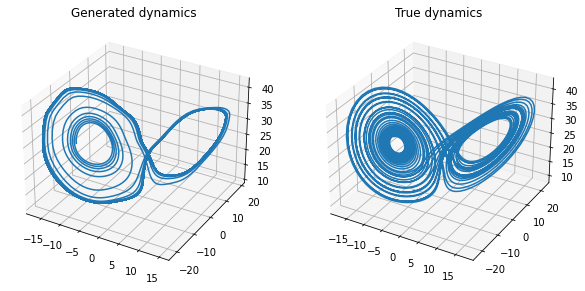

In [42]:
net_states = np.array(net_states)
print(net_states.shape)

fig = plt.figure(figsize = (10,20))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")
ax1.plot(net_states[100:, 0], net_states[100:, 1], net_states[100:, 2])
ax1.set_title("Generated dynamics")
ax2.plot(states_dataset[100:, 0],states_dataset[100:, 1], states_dataset[100:, 2])
ax2.set_title("True dynamics")

## Lyapunov exponents prediction

In [79]:
### Dataset generation

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

eps = 0.01 # Perturbation
len_seq = 5 # Length of the pertubed sequence
t = np.arange(0.0, dt*len_seq, dt) # Time array

# Add pertubation dimension and dynamics dimension
print(states_dataset.shape) 
pd = np.expand_dims(states_dataset, axis=1)
pd = np.expand_dims(pd, axis=1)
perturbed_dataset = np.concatenate((pd, pd), axis=2)
perturbed_dataset = np.concatenate((perturbed_dataset, pd), axis=2)
print(perturbed_dataset.shape)


# Add perturbation
for i in range(3):
    perturbed_dataset[:,:,i,i] += eps
    
print(perturbed_dataset[0,:,0,:])

le_dataset = []
# Run the dynamics for all perturbations for len_seq steps
for state in perturbed_dataset:
    ev_dyn0 = np.expand_dims(odeint(f, state[0,0,:], t), axis=1)
    ev_dyn1 = np.expand_dims(odeint(f, state[0,1,:], t), axis=1)
    ev_dyn2 = np.expand_dims(odeint(f, state[0,2,:], t), axis=1)
   
    ev_dyn = np.concatenate((ev_dyn0, ev_dyn1), axis=1)
    ev_dyn = np.concatenate((ev_dyn, ev_dyn2), axis=1)
    le_dataset.append(ev_dyn)

# Convert to numpy
le_dataset = np.array(le_dataset)

(4000, 3)
(4000, 1, 3, 3)
[[1.01 1.   1.  ]]


In [80]:
### Convert to tensor
l_seq = 20
num_sequences = int(4000/l_seq)

le_dataset = torch.tensor(le_dataset, requires_grad=True,dtype=torch.float)


### Dataloader
le_dataloader = DataLoader(le_dataset, batch_size=16, shuffle=True)
print(next(iter(le_dataloader)).shape)

torch.Size([16, 5, 3, 3])


### Trainig

In [81]:
# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_le = Network(input_size, hidden_units, layers_num, drop_p)

Network initialized


In [ ]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_pi.to(device)
# Network in training mode (enable stochastic layers, e.g. dropout)
net_pi.train()



# Create pbar 
pbar = tqdm(range(num_epochs))

for epoch_num in pbar:
    epoch_losses = []
    
    i = 0
    for batch_sample in le_dataloader:
        
        ### Move samples to the proper device
        batch_sample = batch_sample.to(device)

        ### Prepare network input and labels
        net_input  = batch_sample[:, :-1, :]
        labels = batch_sample[:, 1:, :]

        ### Forward pass
        # Clear previous recorded gradients
        optimizer.zero_grad()
        # Forward pass
        net_out, _ = net_pi(net_input) # we do not need the rnn state at this point, we can ignore the output with "_"
    
        ### Update network
        # Evaluate data driven loss
        dd_loss = loss_fn(net_out, labels)
        # Evaluate physical informed loss
        pi_loss = piloss_fn(net_input,net_out)
        
        loss = beta[i]*dd_loss + pi_loss
    
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Save batch loss
        epoch_losses.append(loss.data.cpu().numpy())
        
        # Update counter
        i = i+1
        
  
    # Compute epoch loss
    epoch_loss = np.mean(epoch_losses)
    
    # Set description
    pbar.set_description("Train loss: %s" %round(np.mean(epoch_losses),3))
    
    # Append
    log_loss.append(epoch_loss)
